In [82]:
# https://www.tensorflow.org/tutorials/images/classification 참고하기
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [83]:
import pathlib
data_dir = r'C:\Users\user\Downloads\drink\drink'  # 폴더 불러오기
data_dir = pathlib.Path(data_dir)

In [84]:
image_count = len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.png')))
print(image_count)

3886


In [85]:
#이미지 크기 변환
batch_size = 32
img_height = 200
img_width = 200

In [86]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=256,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3886 files belonging to 16 classes.
Using 3109 files for training.


In [87]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=256,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3886 files belonging to 16 classes.
Using 777 files for validation.


In [88]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '10', '11', '12', '13', '14', '15', '2', '3', '4', '5', '6', '7', '8', '9']


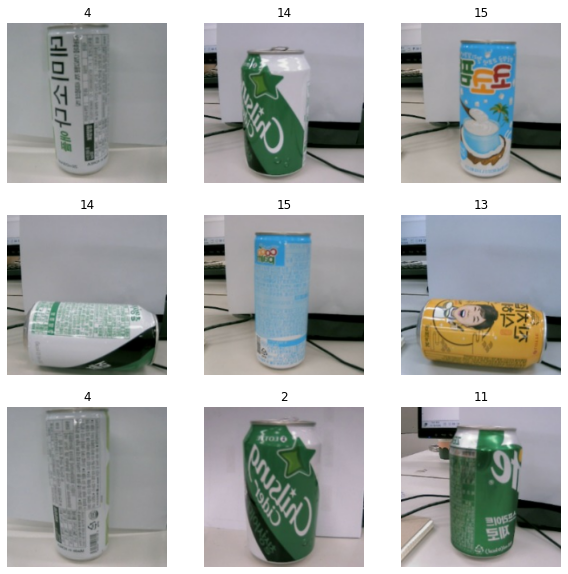

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [91]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 200, 200, 3)
(32,)


In [92]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE) #랜덤으로 섞기

In [93]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255) #정규화

In [94]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.91749054


In [95]:
#sequential모델 레이어 구축
num_classes = 16

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [96]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])#모델

In [97]:
model.summary() #레이어 확인

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_8 (Rescaling)      (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 200, 200, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 100, 100, 32)      4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 25, 25, 64)       

In [98]:
#모델훈련
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
98/98 [==============================] - 44s 445ms/step - loss: 0.9871 - accuracy: 0.7343 - val_loss: 0.2138 - val_accuracy: 0.9575
Epoch 2/10
98/98 [==============================] - 43s 438ms/step - loss: 0.1360 - accuracy: 0.9752 - val_loss: 0.2156 - val_accuracy: 0.9678
Epoch 3/10
98/98 [==============================] - 43s 438ms/step - loss: 0.0389 - accuracy: 0.9910 - val_loss: 0.2053 - val_accuracy: 0.9678
Epoch 4/10
98/98 [==============================] - 43s 440ms/step - loss: 0.0236 - accuracy: 0.9932 - val_loss: 0.1931 - val_accuracy: 0.9704
Epoch 5/10
98/98 [==============================] - 43s 440ms/step - loss: 0.0090 - accuracy: 0.9977 - val_loss: 0.1945 - val_accuracy: 0.9717
Epoch 6/10
98/98 [==============================] - 43s 441ms/step - loss: 0.0028 - accuracy: 0.9994 - val_loss: 0.1637 - val_accuracy: 0.9794
Epoch 7/10
98/98 [==============================] - 44s 447ms/step - loss: 0.0332 - accuracy: 0.9923 - val_loss: 0.3249 - val_accuracy: 0.9614

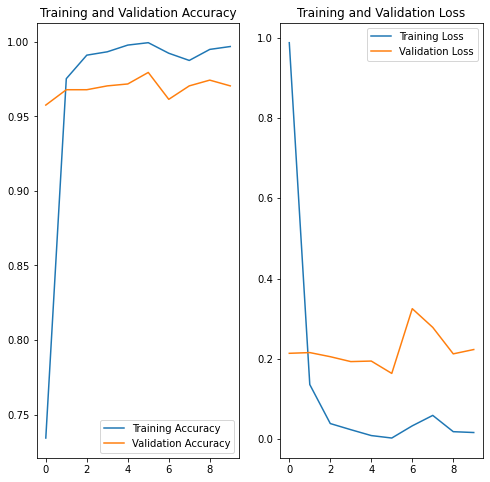

In [99]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [100]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)#이미지 회전

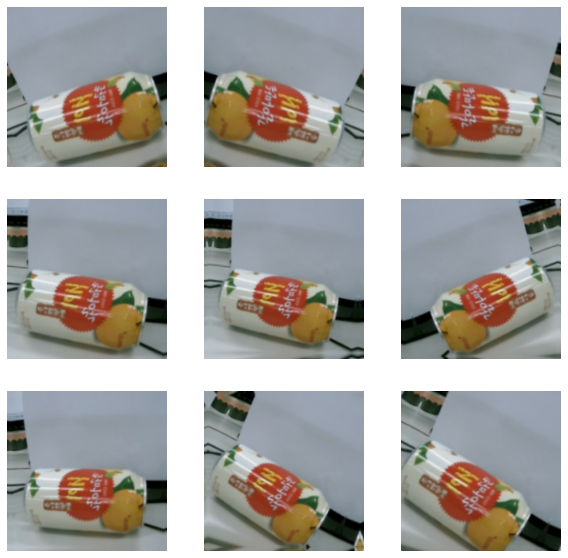

In [101]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [102]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])#모델 생성

In [103]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [104]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 200, 200, 3)       0         
_________________________________________________________________
rescaling_9 (Rescaling)      (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 200, 200, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 100, 100, 32)      4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 50, 50, 64)       

In [105]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
98/98 [==============================] - 49s 496ms/step - loss: 1.4061 - accuracy: 0.5854 - val_loss: 0.4434 - val_accuracy: 0.8584
Epoch 2/15
98/98 [==============================] - 49s 499ms/step - loss: 0.3146 - accuracy: 0.9283 - val_loss: 0.2985 - val_accuracy: 0.9344
Epoch 3/15
98/98 [==============================] - 49s 497ms/step - loss: 0.2472 - accuracy: 0.9472 - val_loss: 0.3154 - val_accuracy: 0.9305
Epoch 4/15
98/98 [==============================] - 49s 505ms/step - loss: 0.1628 - accuracy: 0.9659 - val_loss: 0.1829 - val_accuracy: 0.9781
Epoch 5/15
98/98 [==============================] - 50s 508ms/step - loss: 0.1115 - accuracy: 0.9739 - val_loss: 0.2159 - val_accuracy: 0.9627
Epoch 6/15
98/98 [==============================] - 50s 508ms/step - loss: 0.0907 - accuracy: 0.9791 - val_loss: 0.2016 - val_accuracy: 0.9781
Epoch 7/15
98/98 [==============================] - 48s 489ms/step - loss: 0.0598 - accuracy: 0.9858 - val_loss: 0.2101 - val_accuracy: 0.9717

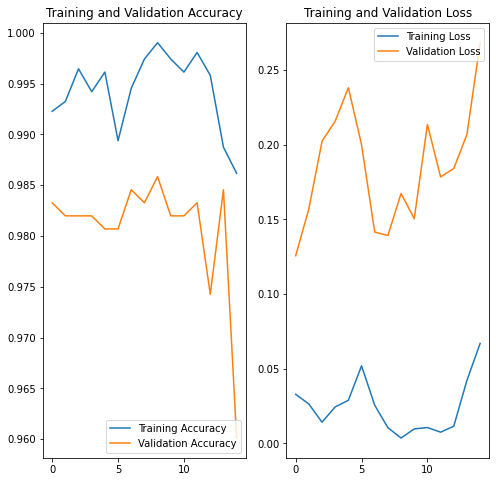

In [81]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [76]:
test_dir = r"C:\Users\user\Downloads\drink\drink\10\201.jpg"
test_dir = pathlib.Path(test_dir)

img = keras.preprocessing.image.load_img(test_dir, target_size=(img_height, img_width))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to 4 with a 96.95 percent confidence.
